In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [ ]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import re
import networkx as nx

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
# from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
from analysis.dataframes2 import *
# from analysis.volumes import *
from helpers.ep_helpers import WallNormal
import math
from itertools import product
from analysis.cp_eq import calc_cp

from typing import NamedTuple


sns.set_style("darkgrid")

In [8]:
cases = retrieve_cases()

In [9]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "red" in i.case_name]
case

CaseData(case_name='Medium_case_red_b1', idf=<geomeppy.idf.IDF object at 0x155df0760>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_red_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1'))

In [35]:
wind_dirs = [i*0.5 for i in range(721)]

In [36]:
def compute_incident_wind_dir_angle(wall_normal, wind_dir):
    res = wind_dir - wall_normal
    inc_angle = 360 - res if res > 180 else res # hmmm... 
    return inc_angle
    

In [278]:
side_ratio_map = {
    "NORTH": math.log(8/5),
    "SOUTH": math.log(8/5),
    "EAST": math.log(5/8),
    "WEST": math.log(5/6),
}

class AngleSurfacePair(NamedTuple):
    wall_normal: WallNormal
    wind_dir: float

class IncidentAngleData(NamedTuple):
    wall_normal_name: str
    wind_dir: float
    incident_angle: float

    @property
    def side_ratio_fac(self):
        return side_ratio_map[self.wall_normal_name]


In [ ]:
side_ratio_map = {
    "NORTH": math.log(8/5),
    "SOUTH": math.log(8/5),
    "EAST": math.log(5/8),
    "WEST": math.log(5/6),
}

In [282]:
angles_data =[ AngleSurfacePair(*j) for j in product([i for i in WallNormal], wind_dirs)]
incident_angles = [IncidentAngleData(i.wall_normal.name, i.wind_dir, compute_incident_wind_dir_angle(i.wall_normal.value, i.wind_dir)) for i in angles_data]
cps = [calc_cp(i.incident_angle) for i in incident_angles]
df = pl.DataFrame(data= {
    "wall_normal": [i.wall_normal_name for i in incident_angles],
    "wind_dir": [i.wind_dir for i in incident_angles],
    "incident_angle": [i.incident_angle for i in incident_angles],
    "cp": [calc_cp(i.incident_angle,i.side_ratio_fac) for i in incident_angles]
})
df

wall_normal,wind_dir,incident_angle,cp
str,f64,f64,f64
"""NORTH""",0.0,0.0,0.603459
"""NORTH""",0.5,0.5,0.602762
"""NORTH""",1.0,1.0,0.602015
"""NORTH""",1.5,1.5,0.601219
"""NORTH""",2.0,2.0,0.600373
…,…,…,…
"""WEST""",358.0,88.0,-0.425866
"""WEST""",358.5,88.5,-0.436428
"""WEST""",359.0,89.0,-0.44696


In [15]:
# df = df.with_columns(adj_wind_dir=pl.when(pl.col("wind_dir") > 180).then(180 - pl.col("wind_dir") ).otherwise(pl.col("wind_dir") ))
# df.head()

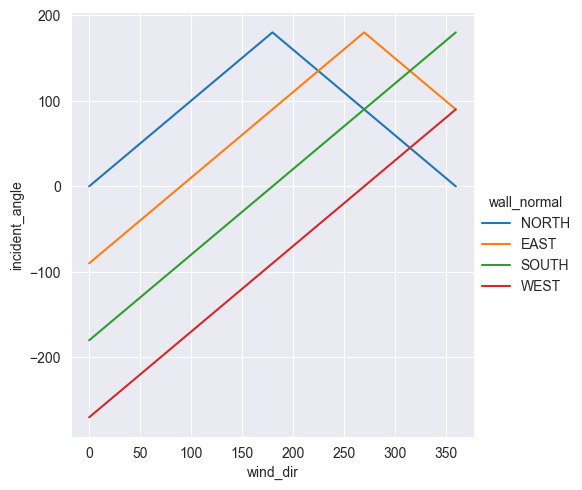

In [283]:
sns.relplot(df, x="wind_dir", y="incident_angle", hue="wall_normal", kind="line")

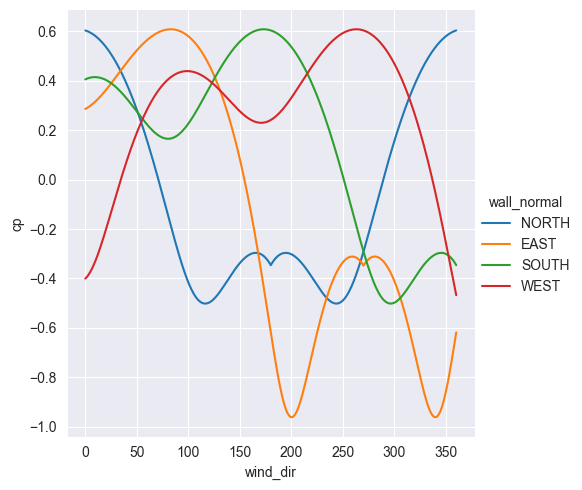

In [284]:
sns.relplot(df, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [40]:
df_pressure = get_external_node_df(case)
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg]
str,str,datetime[μs],f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:00:00,-0.201207,1.425,305.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:15:00,-0.19519,1.35,300.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:30:00,-0.164612,1.275,295.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:45:00,-0.137344,1.2,290.0
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 01:00:00,-0.126187,1.15,290.0
…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 22:45:00,-0.294717,1.8,310.0
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:00:00,-0.270799,1.725,310.0
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:15:00,-0.247882,1.65,310.0


In [41]:
df_pressure = df_pressure.with_columns(wind_val= 2/(pl.col("Site Wind Speed [m/s]"))**2)
df_pressure = df_pressure.with_columns(cp_val=pl.col("AFN Node Wind Pressure [Pa]")*pl.col("wind_val"))
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg],wind_val,cp_val
str,str,datetime[μs],f64,f64,f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:00:00,-0.201207,1.425,305.0,0.984918,-0.198173
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:15:00,-0.19519,1.35,300.0,1.097394,-0.214201
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:30:00,-0.164612,1.275,295.0,1.230296,-0.202522
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 00:45:00,-0.137344,1.2,290.0,1.388889,-0.190755
"""Medium_case_red_b1""","""ExtNode 3""",2017-07-01 01:00:00,-0.126187,1.15,290.0,1.512287,-0.190831
…,…,…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 22:45:00,-0.294717,1.8,310.0,0.617284,-0.181924
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:00:00,-0.270799,1.725,310.0,0.672128,-0.182011
"""Medium_case_red_b1""","""ExtNode 5""",2017-07-01 23:15:00,-0.247882,1.65,310.0,0.734619,-0.182099


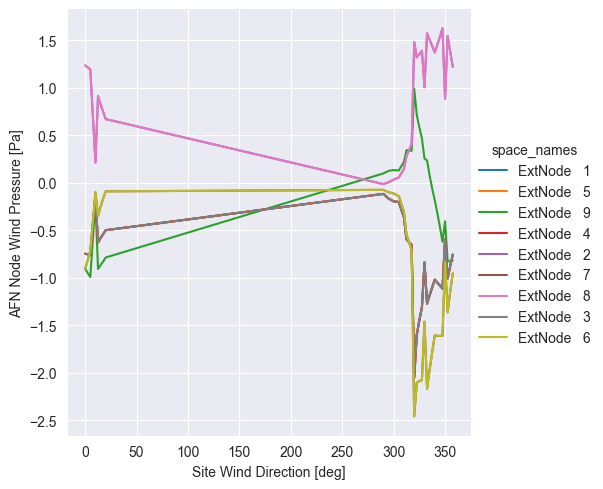

In [20]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="AFN Node Wind Pressure [Pa]", hue="space_names", kind="line", errorbar=None)

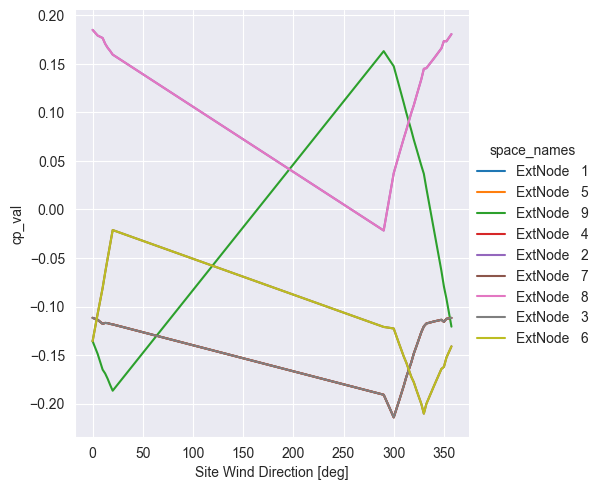

In [21]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="cp_val", hue="space_names", kind="line", errorbar=None)

In [45]:
exp_wind_dirs = list(df_pressure["Site Wind Direction [deg]"].unique())
len(exp_wind_dirs)

31

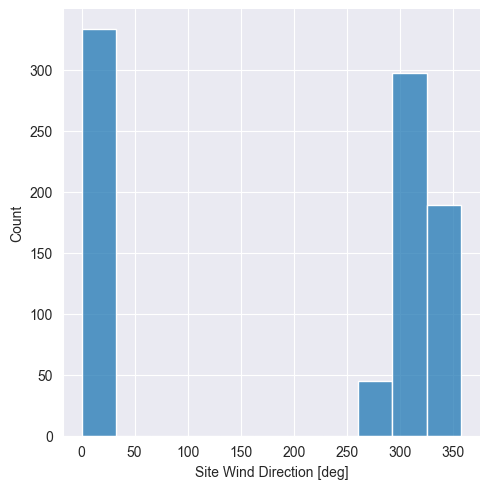

In [22]:
sns.displot(df_pressure, x="Site Wind Direction [deg]")

In [285]:
df_filtered = df.filter(pl.col("wind_dir").is_in(exp_wind_dirs))

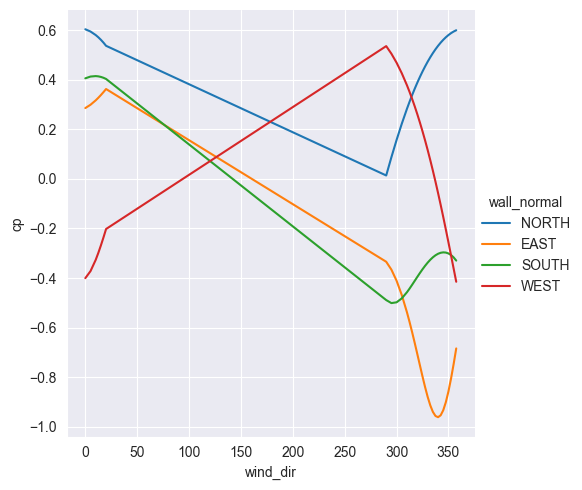

In [286]:
sns.relplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [287]:
df_an = df_filtered.pivot("wall_normal", index="wind_dir", values="cp")
df_an = df_an.rename({"wind_dir": "Site Wind Direction [deg]"})
df_an.head(2)

Site Wind Direction [deg],NORTH,EAST,SOUTH,WEST
f64,f64,f64,f64,f64
0.0,0.603459,0.285501,0.405479,-0.400756
5.0,0.594263,0.298877,0.412654,-0.372372


In [ ]:
df_exp = df_pressure.pivot("space_names", index=["datetimes", "Site Wind Direction [deg]"], values="cp_val",)
df_exp.head(2)

datetimes,Site Wind Direction [deg],ExtNode 3,ExtNode 2,ExtNode 8,ExtNode 7,ExtNode 9,ExtNode 4,ExtNode 1,ExtNode 6,ExtNode 5
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,305.0,-0.198173,0.055535,0.055535,-0.137395,0.128675,-0.198173,-0.198173,-0.137395,-0.198173
2017-07-01 00:15:00,300.0,-0.214201,0.037396,0.037396,-0.122679,0.147534,-0.214201,-0.214201,-0.122679,-0.214201


<Axes: xlabel='Site Wind Direction [deg]', ylabel='Count'>

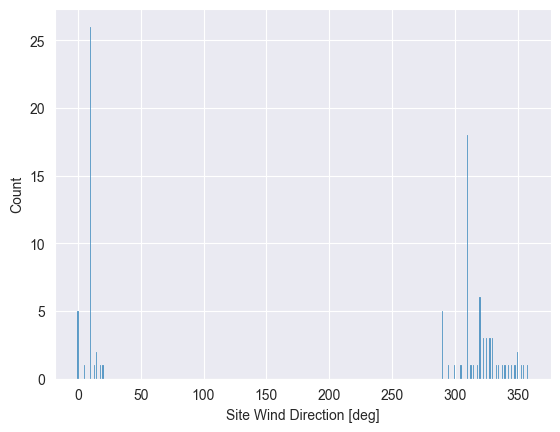

In [197]:
sns.histplot(df_exp, x="Site Wind Direction [deg]", discrete=True, )

In [184]:
df_exp["Site Wind Direction [deg]"].unique()

Site Wind Direction [deg]
f64
0.0
5.0
10.0
12.5
15.0
…
347.5
350.0
352.5


In [ ]:
def find_corr_pair(col_a, col_b):
    res = df_exp.select(pl.corr(col_a, col_b , method="spearman"))
    assert not (res[col_a].is_nan()).all()
    corr = res[col_a].to_list()[0]
    if corr == 1:
            return(col_a, col_b)
    return None

ext_cols = sorted(df_exp.select(cs.contains("Ext")).columns)
pairs = list(product(ext_cols, ext_cols))

corrs = [find_corr_pair(*p) for p in pairs]



In [ ]:
filtered_corrs = [tuple(sorted(i)) for i in corrs if i]
unique_corrs = list(set(filtered_corrs))
G=nx.from_edgelist(unique_corrs)
l=list(nx.connected_components(G))
independent_nodes = [list(i)[0] for i in l]
independent_nodes


In [256]:
df_ind = df_exp.select(["Site Wind Direction [deg]"] + independent_nodes)
df_ind = df_ind.select(pl.col("*").fill_nan(None)).drop_nulls()
df_ind.head(), df_ind.shape

(shape: (5, 5)
 ┌───────────────────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
 │ Site Wind Direction [deg] ┆ ExtNode   3 ┆ ExtNode   7 ┆ ExtNode   2 ┆ ExtNode   9 │
 │ ---                       ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
 │ f64                       ┆ f64         ┆ f64         ┆ f64         ┆ f64         │
 ╞═══════════════════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
 │ 305.0                     ┆ -0.198173   ┆ -0.137395   ┆ 0.055535    ┆ 0.128675    │
 │ 300.0                     ┆ -0.214201   ┆ -0.122679   ┆ 0.037396    ┆ 0.147534    │
 │ 295.0                     ┆ -0.202522   ┆ -0.121817   ┆ 0.007972    ┆ 0.155215    │
 │ 290.0                     ┆ -0.190755   ┆ -0.120953   ┆ -0.021687   ┆ 0.162961    │
 │ 290.0                     ┆ -0.190831   ┆ -0.121001   ┆ -0.021696   ┆ 0.163026    │
 └───────────────────────────┴─────────────┴─────────────┴─────────────┴─────────────┘,
 (95, 5))

In [258]:
# with pl.Config(tbl_rows=100):
#     print(df_ind.sort(by="Site Wind Direction [deg]"))

In [288]:
df_ind_agg = df_ind.group_by("Site Wind Direction [deg]").mean()
df_ind_agg.sort(by="Site Wind Direction [deg]")

Site Wind Direction [deg],ExtNode 3,ExtNode 7,ExtNode 2,ExtNode 9
f64,f64,f64,f64,f64
0.0,-0.111667,-0.135735,0.185035,-0.135735
5.0,-0.113636,-0.107668,0.179193,-0.148756
10.0,-0.117877,-0.080813,0.176653,-0.165081
12.5,-0.116928,-0.065111,0.170733,-0.169004
15.0,-0.11712,-0.050312,0.166558,-0.174483
…,…,…,…,…
347.5,-0.113683,-0.164313,0.165994,-0.063304
350.0,-0.115834,-0.16222,0.173592,-0.079412
352.5,-0.112647,-0.152638,0.173199,-0.091894


<Axes: xlabel='Site Wind Direction [deg]', ylabel='ExtNode   3'>

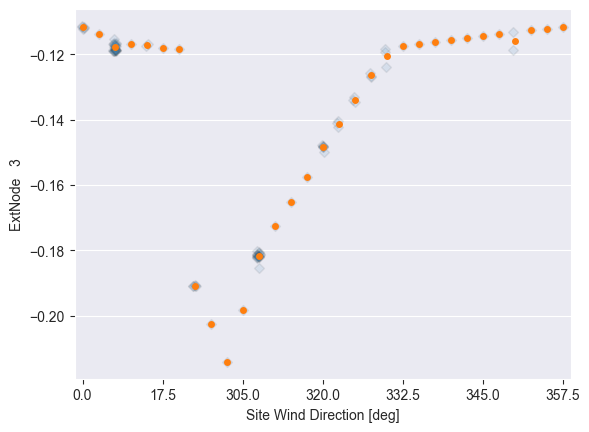

In [260]:
g = sns.stripplot(data=df_ind, x="Site Wind Direction [deg]", y="ExtNode   3", marker="D", linewidth=1, alpha=.1,)
sns.stripplot(df_ind_agg, x="Site Wind Direction [deg]", y="ExtNode   3")
set_axis_ticks(g)

In [289]:
df_join = df_ind_agg.join(df_an, on=["Site Wind Direction [deg]"])
dir_cols = [i.name for i in WallNormal]
df_join.head(2), df_join.shape


(shape: (2, 9)
 ┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬──────────┬───────────┐
 │ Site Wind  ┆ ExtNode    ┆ ExtNode   ┆ ExtNode   ┆ … ┆ NORTH    ┆ EAST     ┆ SOUTH    ┆ WEST      │
 │ Direction  ┆ 3          ┆ 7         ┆ 2         ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
 │ [deg]      ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
 │ ---        ┆ f64        ┆ f64       ┆ f64       ┆   ┆          ┆          ┆          ┆           │
 │ f64        ┆            ┆           ┆           ┆   ┆          ┆          ┆          ┆           │
 ╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪══════════╪═══════════╡
 │ 0.0        ┆ -0.111667  ┆ -0.135735 ┆ 0.185035  ┆ … ┆ 0.603459 ┆ 0.285501 ┆ 0.405479 ┆ -0.400756 │
 │ 5.0        ┆ -0.113636  ┆ -0.107668 ┆ 0.179193  ┆ … ┆ 0.594263 ┆ 0.298877 ┆ 0.412654 ┆ -0.372372 │
 └────────────┴────────────┴───────────┴───────────┴───┴──────────┴

In [ ]:
def get_dif(col_a, col_b):
    return (df_join[col_a] - df_join[col_b]).alias(f"{col_a}__{col_b}")


In [312]:
col_pairs = list(product(ext_cols, dir_cols))
difs = [get_dif(*p) for p in col_pairs]
df_diff = pl.DataFrame(difs)
df_diff.insert_column(0, df_join["Site Wind Direction [deg]"])
df_diff


Site Wind Direction [deg],ExtNode 2__NORTH,ExtNode 2__EAST,ExtNode 2__SOUTH,ExtNode 2__WEST,ExtNode 3__NORTH,ExtNode 3__EAST,ExtNode 3__SOUTH,ExtNode 3__WEST,ExtNode 7__NORTH,ExtNode 7__EAST,ExtNode 7__SOUTH,ExtNode 7__WEST,ExtNode 9__NORTH,ExtNode 9__EAST,ExtNode 9__SOUTH,ExtNode 9__WEST
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-0.418424,-0.100465,-0.220444,0.585791,-0.715126,-0.397168,-0.517146,0.289089,-0.739194,-0.421236,-0.541214,0.265021,-0.739194,-0.421236,-0.541214,0.265021
5.0,-0.41507,-0.119684,-0.23346,0.551565,-0.707899,-0.412513,-0.526289,0.258736,-0.701932,-0.406546,-0.520322,0.264704,-0.743019,-0.447633,-0.56141,0.223616
10.0,-0.403449,-0.139932,-0.237828,0.503602,-0.697979,-0.434462,-0.532358,0.209072,-0.660915,-0.397398,-0.495294,0.246136,-0.745183,-0.481666,-0.579562,0.161868
12.5,-0.400411,-0.15614,-0.242717,0.469889,-0.688072,-0.443801,-0.530377,0.182229,-0.636254,-0.391984,-0.47856,0.234046,-0.740148,-0.495877,-0.582453,0.130153
15.0,-0.394367,-0.171437,-0.244599,0.435319,-0.678044,-0.455115,-0.528276,0.151642,-0.611236,-0.388307,-0.461468,0.21845,-0.735407,-0.512477,-0.585639,0.094279
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
347.5,-0.40515,1.066805,0.463539,0.370769,-0.684826,0.787128,0.183862,0.091092,-0.735457,0.736498,0.133232,0.040462,-0.634447,0.837507,0.234241,0.141471
350.0,-0.40651,1.031159,0.47466,0.43005,-0.695936,0.741733,0.185234,0.140624,-0.742322,0.695347,0.138848,0.094238,-0.659515,0.778155,0.221656,0.177046
352.5,-0.414608,0.978859,0.480677,0.48223,-0.700453,0.693013,0.194832,0.196384,-0.740445,0.653022,0.15484,0.156393,-0.679701,0.713766,0.215584,0.217137


In [313]:
df_diff_long = df_diff.unpivot(index="Site Wind Direction [deg]")
df_diff_long = df_diff_long.with_columns(split_names=pl.col("variable").str.split(by="__"))
df_diff_long

Site Wind Direction [deg],variable,value,split_names
f64,str,f64,list[str]
0.0,"""ExtNode 2__NORTH""",-0.418424,"[""ExtNode 2"", ""NORTH""]"
5.0,"""ExtNode 2__NORTH""",-0.41507,"[""ExtNode 2"", ""NORTH""]"
10.0,"""ExtNode 2__NORTH""",-0.403449,"[""ExtNode 2"", ""NORTH""]"
12.5,"""ExtNode 2__NORTH""",-0.400411,"[""ExtNode 2"", ""NORTH""]"
15.0,"""ExtNode 2__NORTH""",-0.394367,"[""ExtNode 2"", ""NORTH""]"
…,…,…,…
347.5,"""ExtNode 9__WEST""",0.141471,"[""ExtNode 9"", ""WEST""]"
350.0,"""ExtNode 9__WEST""",0.177046,"[""ExtNode 9"", ""WEST""]"
352.5,"""ExtNode 9__WEST""",0.217137,"[""ExtNode 9"", ""WEST""]"


In [314]:
df_diff_long = df_diff_long.lazy().with_columns([
    pl.col("split_names").list.get(pl.lit(0)).alias("node"),
    pl.col("split_names").list.get(pl.lit(1)).alias("drn")
]).collect()
df_diff2 = df_diff_long.drop(["variable", "split_names"])
df_diff2


Site Wind Direction [deg],value,node,drn
f64,f64,str,str
0.0,-0.418424,"""ExtNode 2""","""NORTH"""
5.0,-0.41507,"""ExtNode 2""","""NORTH"""
10.0,-0.403449,"""ExtNode 2""","""NORTH"""
12.5,-0.400411,"""ExtNode 2""","""NORTH"""
15.0,-0.394367,"""ExtNode 2""","""NORTH"""
…,…,…,…
347.5,0.141471,"""ExtNode 9""","""WEST"""
350.0,0.177046,"""ExtNode 9""","""WEST"""
352.5,0.217137,"""ExtNode 9""","""WEST"""


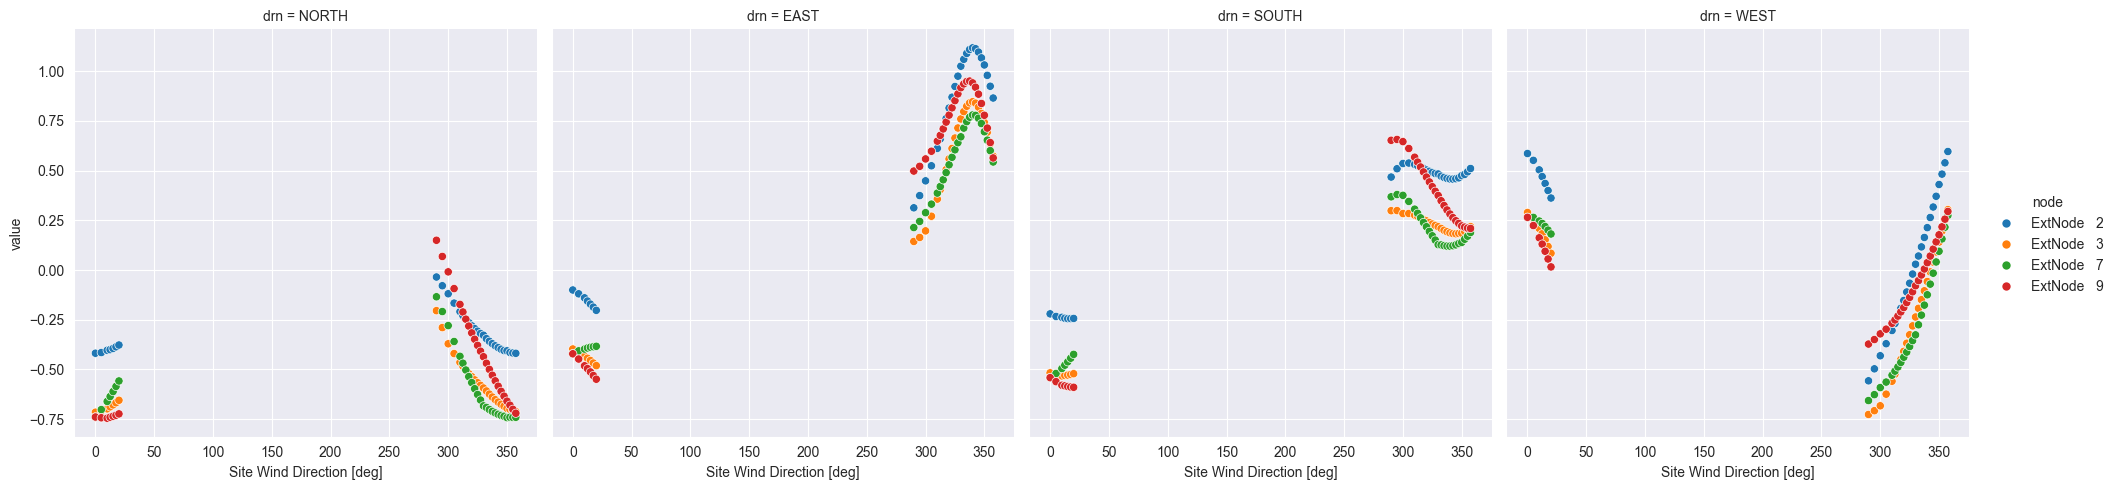

In [315]:
sns.relplot(df_diff2, x="Site Wind Direction [deg]", y="value", col="drn", hue="node")

In [266]:
(df_join["ExtNode   3"] - df_join["NORTH"]).alias("res")


res
f64
-0.715126
-0.707876
-0.697822
-0.687773
-0.677536
…
-0.684528
-0.695779
-0.700384


In [262]:
df_join.with_columns((pl.col("ExtNode   3") - pl.col("SOUTH")).alias("test") )

Site Wind Direction [deg],ExtNode 3,ExtNode 7,ExtNode 2,ExtNode 9,NORTH,EAST,SOUTH,WEST,test
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-0.111667,-0.135735,0.185035,-0.135735,0.603459,0.23212,0.401005,-0.572971,-0.512672
5.0,-0.113636,-0.107668,0.179193,-0.148756,0.594241,0.248685,0.40874,-0.537956,-0.522375
10.0,-0.117877,-0.080813,0.176653,-0.165081,0.579945,0.270703,0.411481,-0.480569,-0.529358
12.5,-0.116928,-0.065111,0.170733,-0.169004,0.570845,0.28346,0.411067,-0.445561,-0.527995
15.0,-0.11712,-0.050312,0.166558,-0.174483,0.560416,0.2972,0.409514,-0.407531,-0.526634
…,…,…,…,…,…,…,…,…,…
347.5,-0.113683,-0.164313,0.165994,-0.063304,0.570845,-0.643719,-0.320302,-0.193907,0.20662
350.0,-0.115834,-0.16222,0.173592,-0.079412,0.579945,-0.612238,-0.32198,-0.243526,0.206146
352.5,-0.112647,-0.152638,0.173199,-0.091894,0.587737,-0.57549,-0.326993,-0.293676,0.214346


In [ ]:
def find_diff():
    pass

In [133]:
df_join = df_ind.join(df_an, on=["Site Wind Direction [deg]"])
df_join.head(2)
dir_cols = [i.name for i in WallNormal]

In [140]:
df_ind_long = df_ind.unpivot(index=["Site Wind Direction [deg]"], variable_name="ExtNode", value_name="Calc_Cp")
df_ind_long.head()

Site Wind Direction [deg],ExtNode,Calc_Cp
f64,str,f64
305.0,"""ExtNode 3""",-0.198173
300.0,"""ExtNode 3""",-0.214201
295.0,"""ExtNode 3""",-0.202522
290.0,"""ExtNode 3""",-0.190755
290.0,"""ExtNode 3""",-0.190831


In [170]:
df_an.head()

Site Wind Direction [deg],NORTH,EAST,SOUTH,WEST
f64,f64,f64,f64,f64
0.0,0.603459,0.23212,0.401005,-0.572971
5.0,0.594241,0.248685,0.40874,-0.537956
10.0,0.579945,0.270703,0.411481,-0.480569
12.5,0.570845,0.28346,0.411067,-0.445561
15.0,0.560416,0.2972,0.409514,-0.407531


In [172]:
df_an_long = df_an.unpivot(index=["Site Wind Direction [deg]"], variable_name="WallNormal", value_name="AnalyticalCp")
df_an_long.head()

Site Wind Direction [deg],WallNormal,AnalyticalCp
f64,str,f64
0.0,"""NORTH""",0.603459
5.0,"""NORTH""",0.594241
10.0,"""NORTH""",0.579945
12.5,"""NORTH""",0.570845
15.0,"""NORTH""",0.560416


In [174]:
df_res = df_ind_long.join(df_an_long, on=["Site Wind Direction [deg]"])
df_res

Site Wind Direction [deg],ExtNode,Calc_Cp,WallNormal,AnalyticalCp
f64,str,f64,str,f64
305.0,"""ExtNode 3""",-0.198173,"""NORTH""",0.193768
305.0,"""ExtNode 3""",-0.198173,"""EAST""",-0.431632
305.0,"""ExtNode 3""",-0.198173,"""SOUTH""",-0.640352
305.0,"""ExtNode 3""",-0.198173,"""WEST""",0.426479
300.0,"""ExtNode 3""",-0.214201,"""NORTH""",0.118805
…,…,…,…,…
310.0,"""ExtNode 9""",0.109913,"""WEST""",0.37807
310.0,"""ExtNode 9""",0.109966,"""NORTH""",0.261896
310.0,"""ExtNode 9""",0.109966,"""EAST""",-0.480705


/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_33519/678487851.py:1: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(df_ind_long, x="Site Wind Direction [deg]", y="Calc_Cp", hue="ExtNode", markers=True, style="ExtNode", palette=sns.dark_palette("#69d"))
/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_33519/678487851.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", palette=sns.color_palette("YlOrBr"), dashes=True, markers=True, style="wall_normal")


<Axes: xlabel='Site Wind Direction [deg]', ylabel='Calc_Cp'>

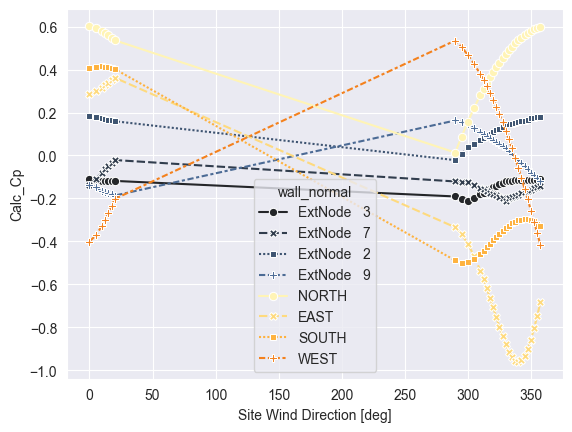

In [290]:
sns.lineplot(df_ind_long, x="Site Wind Direction [deg]", y="Calc_Cp", hue="ExtNode", markers=True, style="ExtNode", palette=sns.dark_palette("#69d"))
# sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")
cmap = sns.color_palette("rocket")
sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", palette=sns.color_palette("YlOrBr"), dashes=True, markers=True, style="wall_normal")

In [ ]:
# maybe have the same change points.. 

In [322]:
corr = df_join.drop("Site Wind Direction [deg]").to_pandas().corr()
corr

,ExtNode 3,ExtNode 7,ExtNode 2,ExtNode 9,NORTH,EAST,SOUTH,WEST
ExtNode 3,1.000000,-0.003506,0.949708,-0.812550,0.955253,0.011664,0.515134,-0.874550
ExtNode 7,-0.003506,1.000000,0.075631,-0.548347,0.072378,0.898805,0.746171,-0.330944
ExtNode 2,0.949708,0.075631,1.000000,-0.863186,0.998532,0.098034,0.573052,-0.920916
ExtNode 9,-0.812550,-0.548347,-0.863186,1.000000,-0.863479,-0.515523,-0.839085,0.956955
NORTH,0.955253,0.072378,0.998532,-0.863479,1.000000,0.083211,0.562377,-0.923335
EAST,0.011664,0.898805,0.098034,-0.515523,0.083211,1.000000,0.851678,-0.310655
SOUTH,0.515134,0.746171,0.573052,-0.839085,0.562377,0.851678,1.000000,-0.688998
WEST,-0.874550,-0.330944,-0.920916,0.956955,-0.923335,-0.310655,-0.688998,1.000000


In [331]:
corr = corr.iloc[0:4, 4:]
corr

,NORTH,EAST,SOUTH,WEST
ExtNode 3,0.955253,0.011664,0.515134,-0.874550
ExtNode 7,0.072378,0.898805,0.746171,-0.330944
ExtNode 2,0.998532,0.098034,0.573052,-0.920916
ExtNode 9,-0.863479,-0.515523,-0.839085,0.956955


<Axes: >

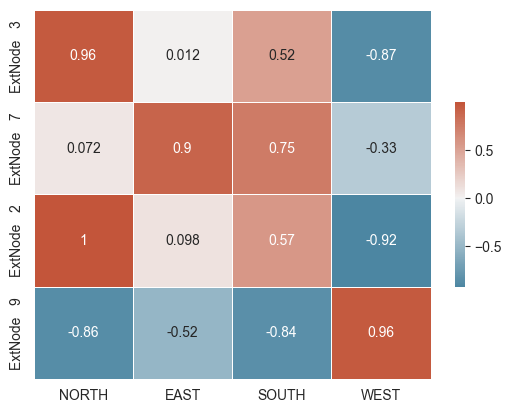

In [337]:
corr = df_join.drop("Site Wind Direction [deg]").to_pandas().corr()
corr = corr.iloc[0:4, 4:]

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, center=0,
             linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

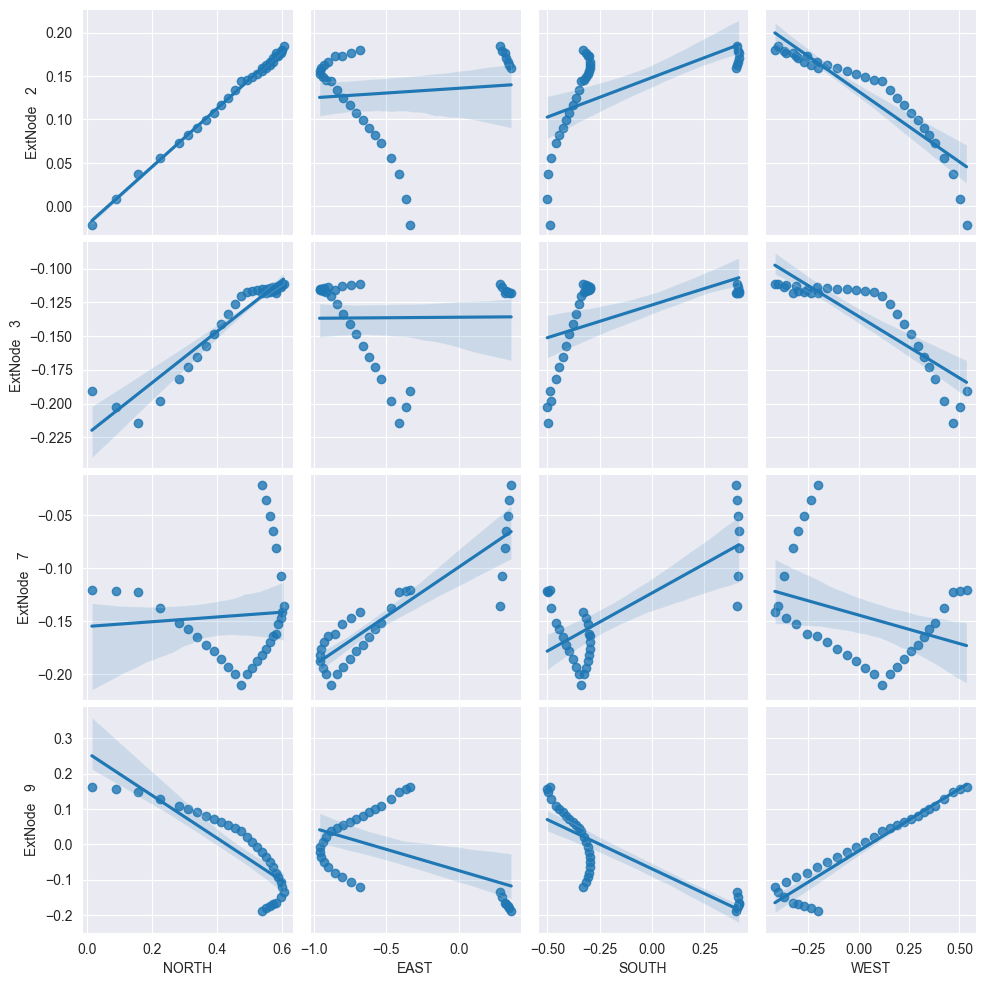

In [338]:
sns.pairplot(df_join.to_pandas(), x_vars=dir_cols, y_vars=ext_cols, kind="reg")

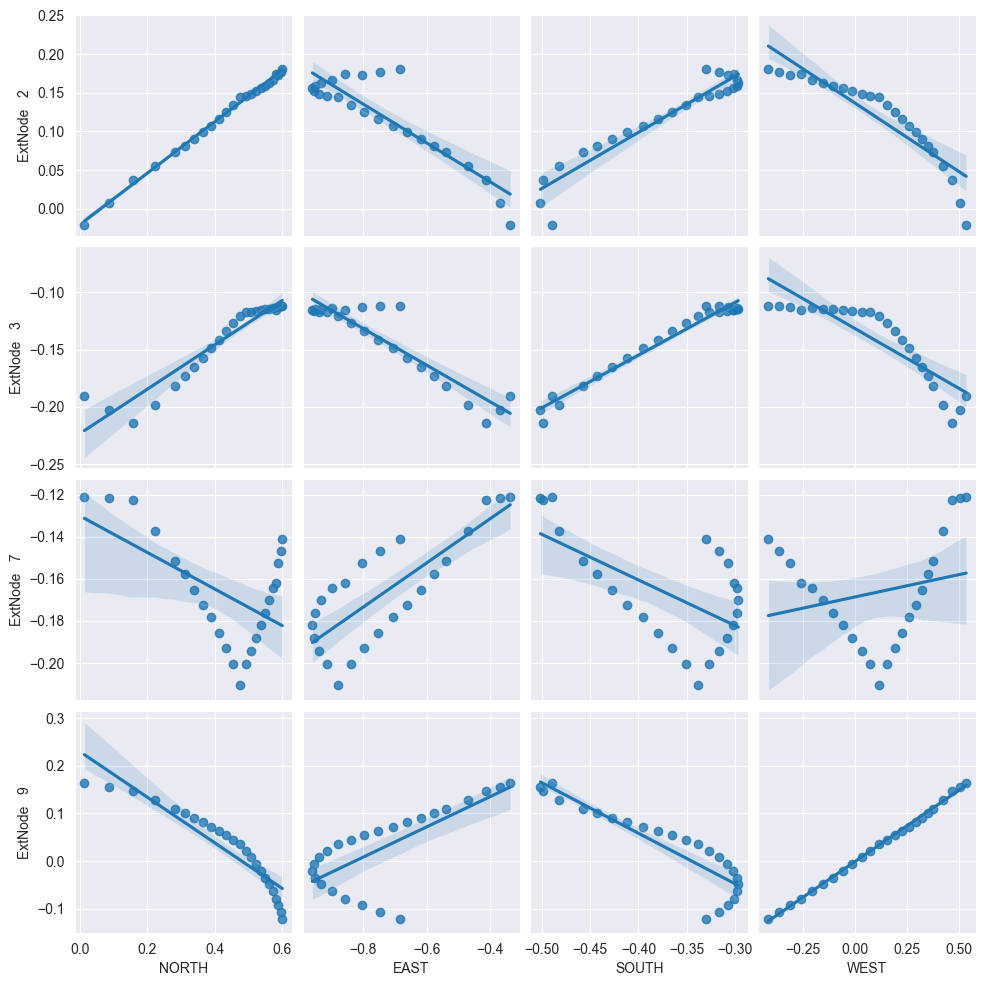

In [317]:
sns.pairplot(df_join.filter(pl.col("Site Wind Direction [deg]") > 250).to_pandas(), x_vars=dir_cols, y_vars=ext_cols, kind="reg")